In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from math import pi

from src.pre_processing import *

/Users/monicacoyarzun/Galvanize/Galvanize_DSI/capstone/Emotrak/src/pre_processing.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  subset['responseLagSeconds'] = subset['responseLagSeconds'].fillna(subset['responseLagSeconds'].mode()[0])
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

In [2]:
pd.set_option('display.max_columns', 999)

### Import from src.pre_processing cleans data, fills NaN's, and takes subset to work with


### Dummify categoricals

In [3]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7426 entries, 0 to 7425
Data columns (total 40 columns):
responseLagSeconds             7426 non-null float64
dailyAlertNumber               7426 non-null float64
tiredness                      7426 non-null float64
feelingEmotion                 7426 non-null int64
generalEmotion                 7426 non-null object
specificEmotion                7426 non-null object
intensity                      7426 non-null float64
generalTrigger                 7426 non-null object
specificTrigger                7426 non-null object
bodySensationIntensity         7426 non-null float64
bodySensationForehead          7426 non-null int64
bodySensationEyes              7426 non-null int64
bodySensationJaw               7426 non-null int64
bodySensationNeck              7426 non-null int64
bodySensationShoulders         7426 non-null int64
bodySensationChest             7426 non-null int64
bodySensationArms              7426 non-null int64
bodySensatio

In [4]:
for col in cols_to_dummify:
    dummify_clustering(subset, col)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
subset.head()

,responseLagSeconds,dailyAlertNumber,tiredness,feelingEmotion,intensity,bodySensationIntensity,bodySensationForehead,bodySensationEyes,bodySensationJaw,bodySensationNeck,bodySensationShoulders,bodySensationChest,bodySensationArms,bodySensationHands,bodySensationStomach,bodySensationBowel,bodySensationLegs,bodySensationFeet,bodySensationLowerBack,bodySensationUpperBack,bodySensationOther,bodySensationOtherLocation,emotionDuration,selfCareEatingWell,selfCareCooking,selfCareExercise,selfCareSeekingSupport,selfCareTimeOutside,selfCareSpiritualPractice,selfCareQualityTimeTogether,selfCareQualityTimeAlone,selfCarePet,selfCareOther,selfCareNone,selfCareOtherActivity,workPilingUp,anger,enjoyment,fear,other,sadness,afraid,angry,annoyed,anxious,ashamed,discouraged,embarrassed,enthusiastic,excited,frustrated,happy,irritated,joyful,lonely,nervous,notListed,peaceful,sad,worried,0,personalConcerns,socialStress,socialSupport,wellbeing,workSatisfaction,workStress,world,bodyImage,clientChallenge,clientEnjoyable,climateChange,colleagueChallenge,colleagueEnjoyable,dislikeJob,domesticPolitics,exercise,familyChallenge,financialStress,friendsChallenge,globalPolitics,healthProblems,healthcare,lackMotivation,paperwork,patientChallenge,patientEnjoyable,play,productivity,relaxation,sleepDeprived,soChallenge,spiritual,success,timeFamily,timeFriends,timeSO,workload
0,2044.0,2.0,0.500000,1,0.50,0.75,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,60.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7642.0,2.0,0.465404,1,0.25,0.50,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,90.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1330.0,4.0,0.465404,1,0.25,0.25,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,73.0,1.0,0.465404,1,0.50,0.50,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,56.0,2.0,0.465404,1,0.50,0.50,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Scale data and PCA

In [6]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(subset)
scaled_subset = scaler.transform(subset)


In [7]:
scaled_subset

array([[0.18360191, 0.25      , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.18409864, 0.25      , 0.46540388, ..., 0.        , 0.        ,
        1.        ],
       [0.18353855, 0.75      , 0.46540388, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.18449164, 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.75      , 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.18342116, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [8]:
svd = TruncatedSVD(n_components=10, n_iter=7)
X_svd = svd.fit_transform(scaled_subset)

In [9]:
svd.singular_values_

array([129.61289475,  67.46710749,  45.19613332,  43.08881899,
        39.94621574,  38.44074133,  34.9331556 ,  33.75558374,
        32.89173213,  29.53612846])

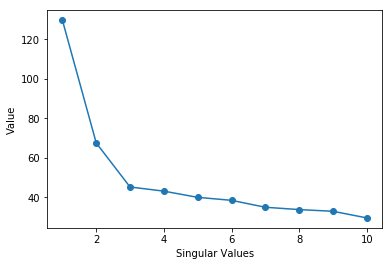

In [10]:
s = svd.singular_values_

x = [i+1 for i in range(len(s))]
plt.plot(x, s, marker='o')
plt.xlabel("Singular Values")
plt.ylabel("Value");

### kMeans Model after PCA

In [11]:
kmeans = KMeans(n_clusters=6, random_state=10)
predictions = kmeans.fit_predict(X_svd)
predictions

array([4, 3, 0, ..., 5, 2, 5], dtype=int32)

In [12]:
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([1235,  854, 1068, 1408, 1850, 1011]))

In [13]:
np.unique(predictions == 1, return_counts=True)[1][1]

854

In [14]:
silhouette_score(X_svd, predictions, metric='euclidean')

0.3286654967218126

### Plot Silhouettes

In [15]:
X = X_svd
range_n_clusters = range(2,10)

# taken from sklearn
def plot_silhouette(X):
    
    for n_clusters in range_n_clusters:
        fig, (ax1) = plt.subplots(1)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
        silhouette_avg = silhouette_score(X, cluster_labels, metric='euclidean')
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.23657457679508892


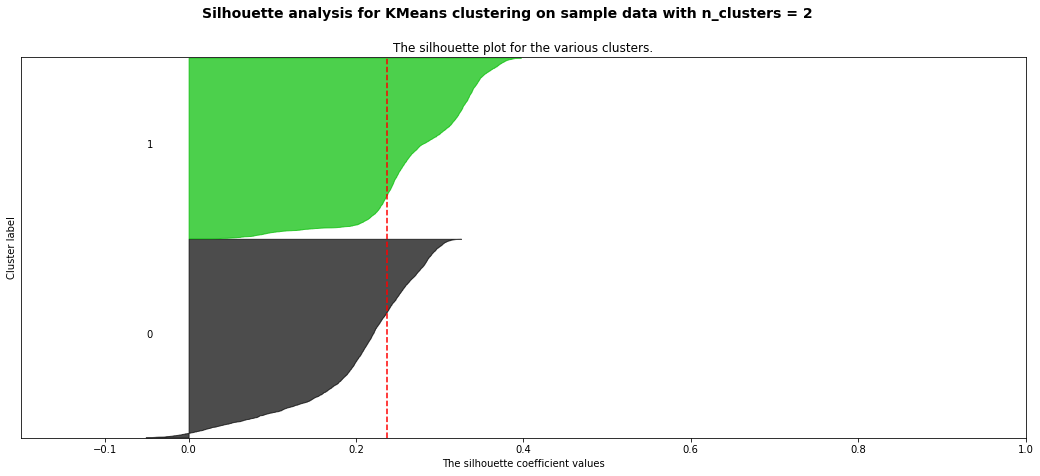

For n_clusters = 3 The average silhouette_score is : 0.2426349043948983


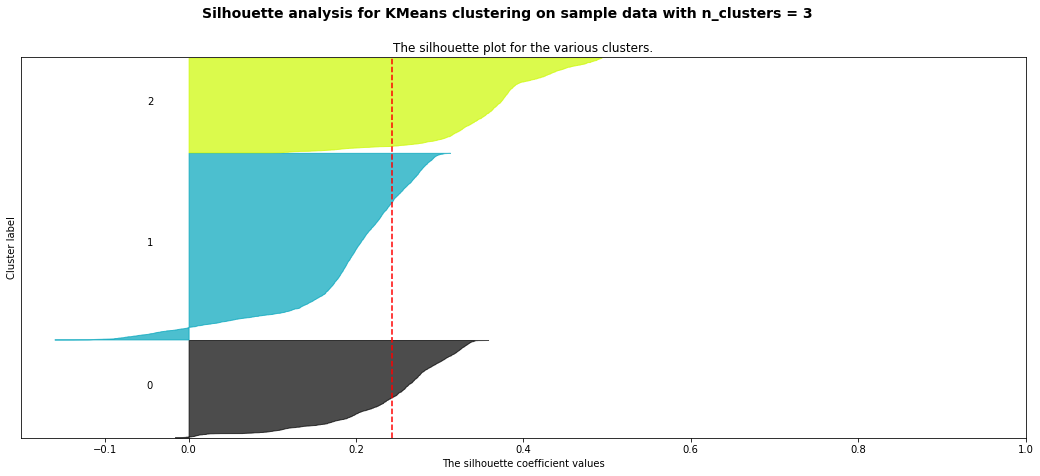

For n_clusters = 4 The average silhouette_score is : 0.26432150884001704


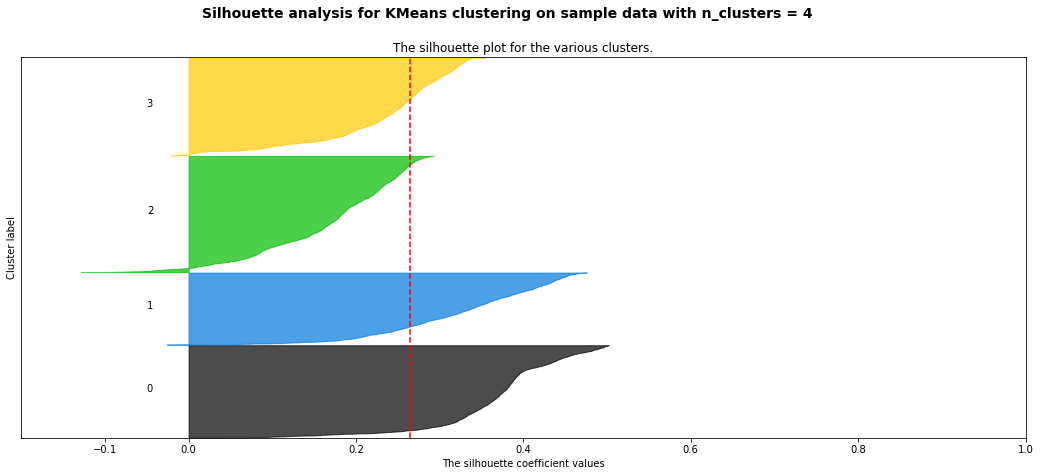

For n_clusters = 5 The average silhouette_score is : 0.2903532186084691


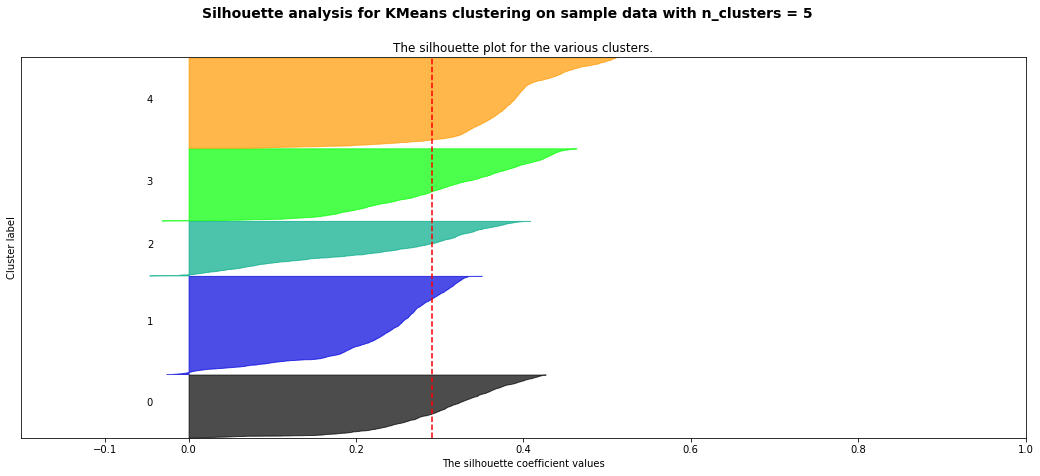

For n_clusters = 6 The average silhouette_score is : 0.3286654967218126


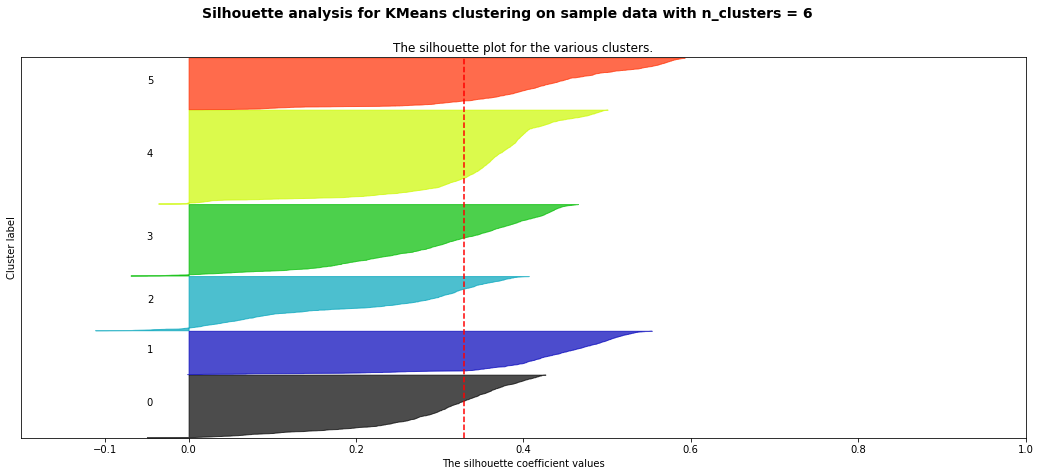

For n_clusters = 7 The average silhouette_score is : 0.3233344747660576


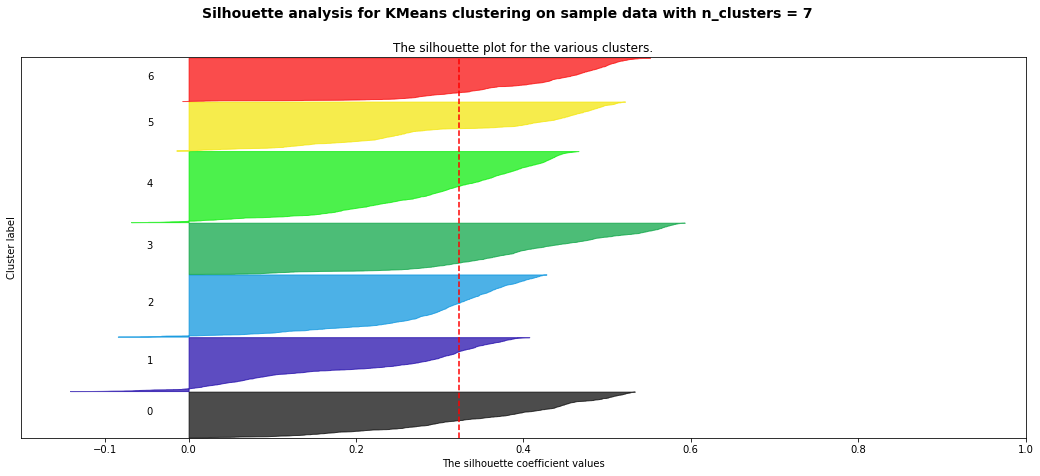

For n_clusters = 8 The average silhouette_score is : 0.32354463618157653


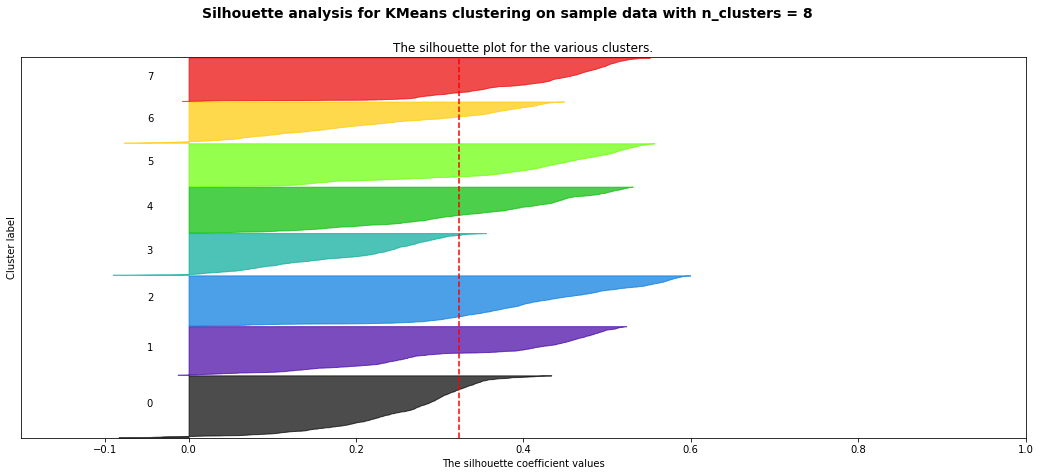

For n_clusters = 9 The average silhouette_score is : 0.33536796265191104


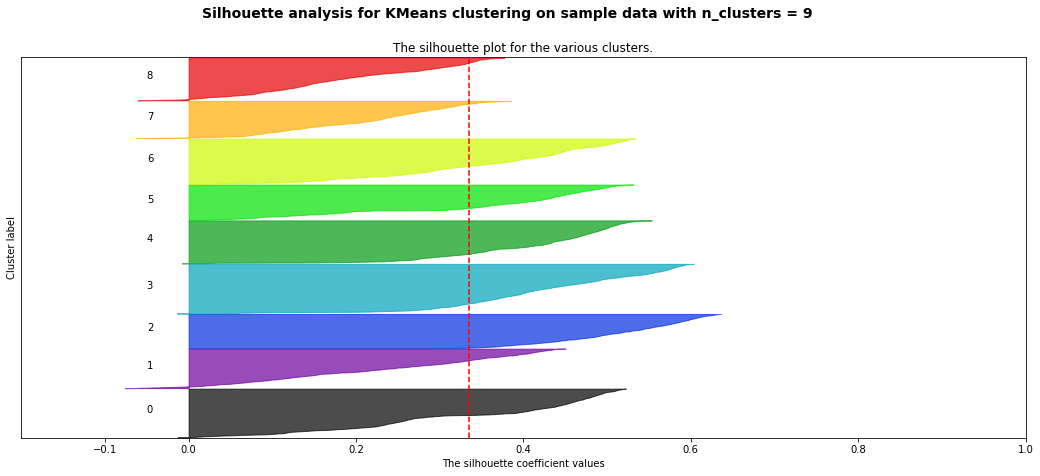

In [16]:
plot_silhouette(X)

### Check key features and add labels to dataframe

In [17]:
centroids = svd.inverse_transform(kmeans.cluster_centers_)
centroids[0]

array([ 1.78998384e-01,  2.76488652e-01,  4.35745774e-01,  6.96984390e-01,
        5.51151667e-01,  4.51193175e-01,  4.11444228e-02,  4.03043783e-02,
        2.92333927e-02,  5.21092773e-02,  5.15013124e-02,  3.58149434e-02,
        3.25429664e-03,  2.20164942e-03,  2.15202442e-02,  2.26937328e-03,
        3.80329654e-03,  1.86720238e-03,  6.46924985e-03,  6.96067326e-03,
        7.95216926e-03,  8.14640308e-03,  3.34139446e-01,  1.43324107e-02,
        1.15329257e-02,  1.22558652e-02,  3.36654849e-03,  1.47261644e-02,
        5.13950392e-03,  2.29608650e-02,  1.22113397e-02,  8.08260884e-03,
        3.14856637e-03,  2.08970816e-02,  0.00000000e+00,  2.84685146e-01,
        9.55778140e-01, -1.80409348e-04, -2.20370746e-02,  3.84498727e-02,
       -3.95471371e-02,  4.32347213e-03,  1.22922370e-01,  2.58724457e-01,
       -3.37356669e-02,  8.22979865e-03, -2.03155935e-02,  4.97482127e-03,
        3.69145449e-03,  3.81117487e-03,  3.10420847e-01, -1.53245652e-02,
        2.63710465e-01,  

In [18]:
top_centroids = np.argsort(centroids)[:, -1:-11:-1]

In [19]:
top_centroids

array([[36,  3,  4,  5,  2, 66, 22, 50, 35,  1],
       [63, 37,  3,  4,  2, 22, 51, 94, 95,  1],
       [ 3, 22, 40,  4,  5, 62, 35, 66,  2, 46],
       [38,  3, 44, 22,  4,  5, 66,  2, 35, 97],
       [64, 37,  3,  4,  2, 87, 57, 22,  5, 89],
       [65, 37,  3,  2,  4, 88, 22,  5, 48, 93]])

In [20]:
for i in range(6):
    print ('Cluster', i+1, 'total: ', np.unique(predictions == i, return_counts=True)[1][1])
    print (subset[predictions == i].iloc[:, top_centroids[i]].columns)
    print ()

Cluster 1 total:  1235
Index(['anger', 'feelingEmotion', 'intensity', 'bodySensationIntensity',
       'tiredness', 'workStress', 'emotionDuration', 'frustrated',
       'workPilingUp', 'dailyAlertNumber'],
      dtype='object')

Cluster 2 total:  854
Index(['socialSupport', 'enjoyment', 'feelingEmotion', 'intensity',
       'tiredness', 'emotionDuration', 'happy', 'timeFamily', 'timeFriends',
       'dailyAlertNumber'],
      dtype='object')

Cluster 3 total:  1068
Index(['feelingEmotion', 'emotionDuration', 'sadness', 'intensity',
       'bodySensationIntensity', 'socialStress', 'workPilingUp', 'workStress',
       'tiredness', 'discouraged'],
      dtype='object')

Cluster 4 total:  1408
Index(['fear', 'feelingEmotion', 'anxious', 'emotionDuration', 'intensity',
       'bodySensationIntensity', 'workStress', 'tiredness', 'workPilingUp',
       'workload'],
      dtype='object')

Cluster 5 total:  1850
Index(['wellbeing', 'enjoyment', 'feelingEmotion', 'intensity', 'tiredness',
     

In [21]:
# for i in top_centroids:
subset[predictions == 0].iloc[:, top_centroids[0]].describe()

,anger,feelingEmotion,intensity,bodySensationIntensity,tiredness,workStress,emotionDuration,frustrated,workPilingUp,dailyAlertNumber
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,0.995951,0.708502,0.525506,0.409514,0.421952,0.416194,32.459109,0.312551,1.091498,2.085735
std,0.063525,0.454636,0.240621,0.316453,0.224348,0.493126,32.649465,0.463721,1.252117,0.997521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.250000,0.000000,0.250000,0.000000,5.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.500000,0.500000,0.465404,0.000000,15.000000,0.000000,1.000000,2.000000
75%,1.000000,1.000000,0.750000,0.750000,0.500000,1.000000,60.000000,1.000000,2.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,1.000000,4.000000,5.000000


In [22]:
subset[predictions == 1].iloc[:, top_centroids[1]].describe()

,socialSupport,enjoyment,feelingEmotion,intensity,tiredness,emotionDuration,happy,timeFamily,timeFriends,dailyAlertNumber
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,0.977752,0.940281,0.689696,0.555913,0.486010,41.734192,0.398126,0.364169,0.366511,2.234056
std,0.147576,0.237104,0.462889,0.200797,0.215882,33.723979,0.489799,0.481478,0.482134,0.977240
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,0.500000,0.250000,15.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,1.000000,1.000000,0.500000,0.500000,30.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,1.000000,0.750000,0.500000,90.000000,1.000000,1.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,1.000000,1.000000,1.000000,5.000000


In [23]:
subset[predictions == 2].iloc[:, top_centroids[2]].describe()

,feelingEmotion,emotionDuration,sadness,intensity,bodySensationIntensity,socialStress,workPilingUp,workStress,tiredness,discouraged
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,0.715356,47.587079,0.674157,0.546348,0.406835,0.352060,1.176966,0.321161,0.372529,0.273408
std,0.451456,35.203318,0.468908,0.241211,0.313855,0.477836,1.302997,0.467141,0.211194,0.445917
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
50%,1.000000,30.000000,1.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.465404,0.000000
75%,1.000000,90.000000,1.000000,0.750000,0.750000,1.000000,2.000000,1.000000,0.500000,1.000000
max,1.000000,90.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000


In [24]:
subset[predictions == 3].iloc[:, top_centroids[3]].describe()

,fear,feelingEmotion,anxious,emotionDuration,intensity,bodySensationIntensity,workStress,tiredness,workPilingUp,workload
count,1408.00000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000
mean,0.99929,0.746449,0.530540,44.818892,0.503374,0.462713,0.480824,0.433667,1.242188,0.265625
std,0.02665,0.435198,0.499244,35.023181,0.234007,0.291788,0.499810,0.224228,1.280884,0.441822
min,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,0.000000,0.000000,15.000000,0.250000,0.250000,0.000000,0.250000,0.000000,0.000000
50%,1.00000,1.000000,1.000000,30.000000,0.500000,0.500000,0.000000,0.465404,1.000000,0.000000
75%,1.00000,1.000000,1.000000,90.000000,0.750000,0.750000,1.000000,0.500000,2.000000,1.000000
max,1.00000,1.000000,1.000000,90.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [25]:
subset[predictions == 4].iloc[:, top_centroids[4]].describe()

,wellbeing,enjoyment,feelingEmotion,intensity,tiredness,play,peaceful,emotionDuration,bodySensationIntensity,relaxation
count,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000
mean,0.956757,0.925946,0.672973,0.550946,0.515019,0.483784,0.476757,37.327027,0.316486,0.301081
std,0.203459,0.261930,0.469254,0.199900,0.238130,0.499872,0.499595,31.318313,0.298452,0.458852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.500000,0.250000,0.000000,0.000000,15.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.500000,0.500000,0.000000,0.000000,30.000000,0.250000,0.000000
75%,1.000000,1.000000,1.000000,0.750000,0.750000,1.000000,1.000000,60.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,1.000000,1.000000


In [26]:
subset[predictions == 5].iloc[:, top_centroids[5]].describe()

,workSatisfaction,enjoyment,feelingEmotion,tiredness,intensity,productivity,emotionDuration,bodySensationIntensity,enthusiastic,success
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,0.950544,0.893175,0.734916,0.552598,0.528932,0.419387,36.576657,0.323689,0.257171,0.230465
std,0.216925,0.309043,0.441596,0.221366,0.195472,0.493703,30.843598,0.284083,0.437291,0.421339
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.465404,0.500000,0.000000,15.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.500000,0.500000,0.000000,30.000000,0.250000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.750000,0.750000,1.000000,60.000000,0.500000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,1.000000,1.000000,1.000000


In [27]:
subset['label'] = pd.Series(predictions, index=subset.index)

In [28]:
subset['label'].value_counts()

4    1850
3    1408
0    1235
2    1068
5    1011
1     854
Name: label, dtype: int64

### Scatter plots

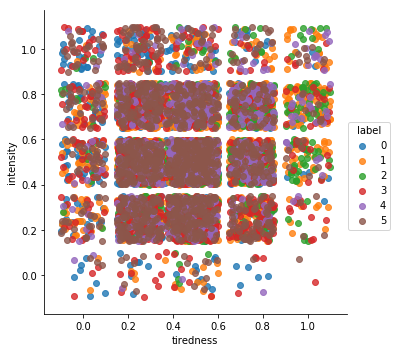

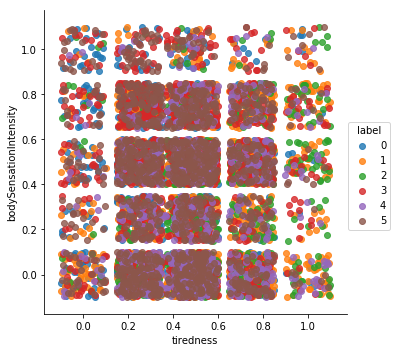

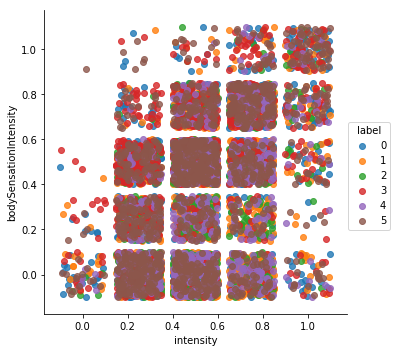

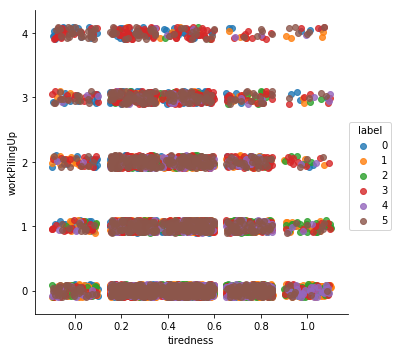

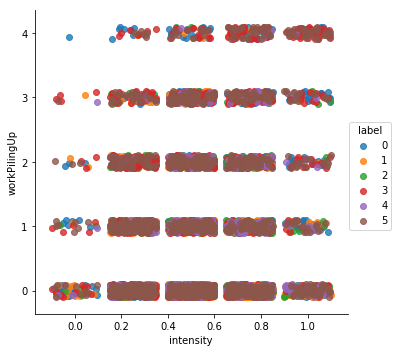

In [35]:
facet = sns.lmplot(data=subset, x='tiredness', y='intensity', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)
facet2 = sns.lmplot(data=subset, x='tiredness', y='bodySensationIntensity', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)
# facet3 = sns.lmplot(data=test_subset, x='tiredness', y='emotionDuration', hue='label', 
#                    fit_reg=False, legend=True, legend_out=True, x_jitter=0, y_jitter=0)
facet4 = sns.lmplot(data=subset, x='intensity', y='bodySensationIntensity', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)
facet5 = sns.lmplot(data=subset, x='tiredness', y='workPilingUp', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=.1)
facet6 = sns.lmplot(data=subset, x='intensity', y='workPilingUp', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)

### Swarm Plots

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2783: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


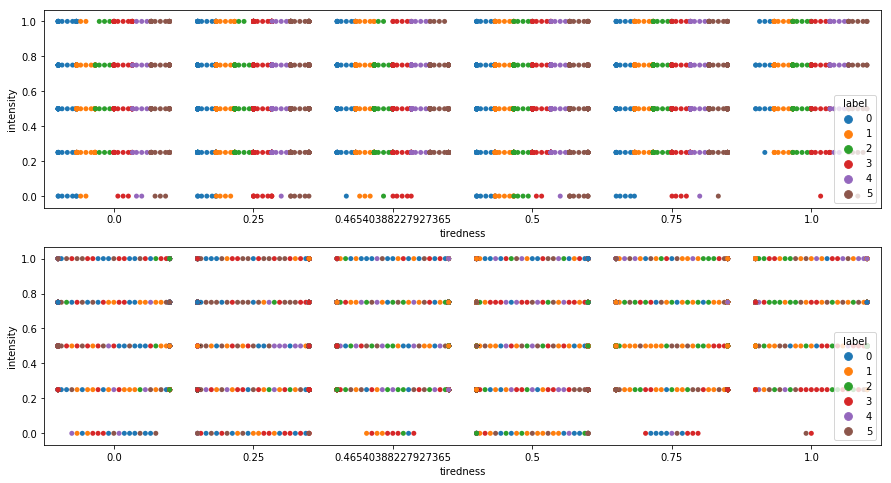

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
# for i in range(6):
sns.swarmplot(x='tiredness', y='intensity', hue='label', split=True, data=subset, ax=ax[0]);
sns.swarmplot(x='tiredness', y='intensity', hue='label', data=subset, ax=ax[1]);

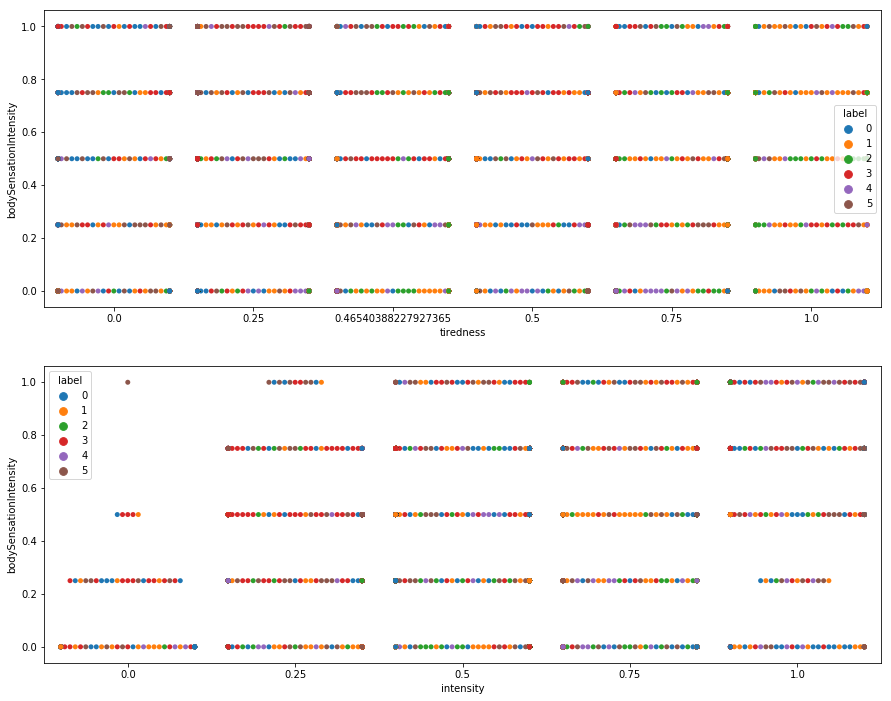

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
# for i in range(6):
sns.swarmplot(x='tiredness', y='bodySensationIntensity', hue='label', data=subset, ax=ax[0]);
sns.swarmplot(x='intensity', y='bodySensationIntensity', hue='label', data=subset, ax=ax[1]);

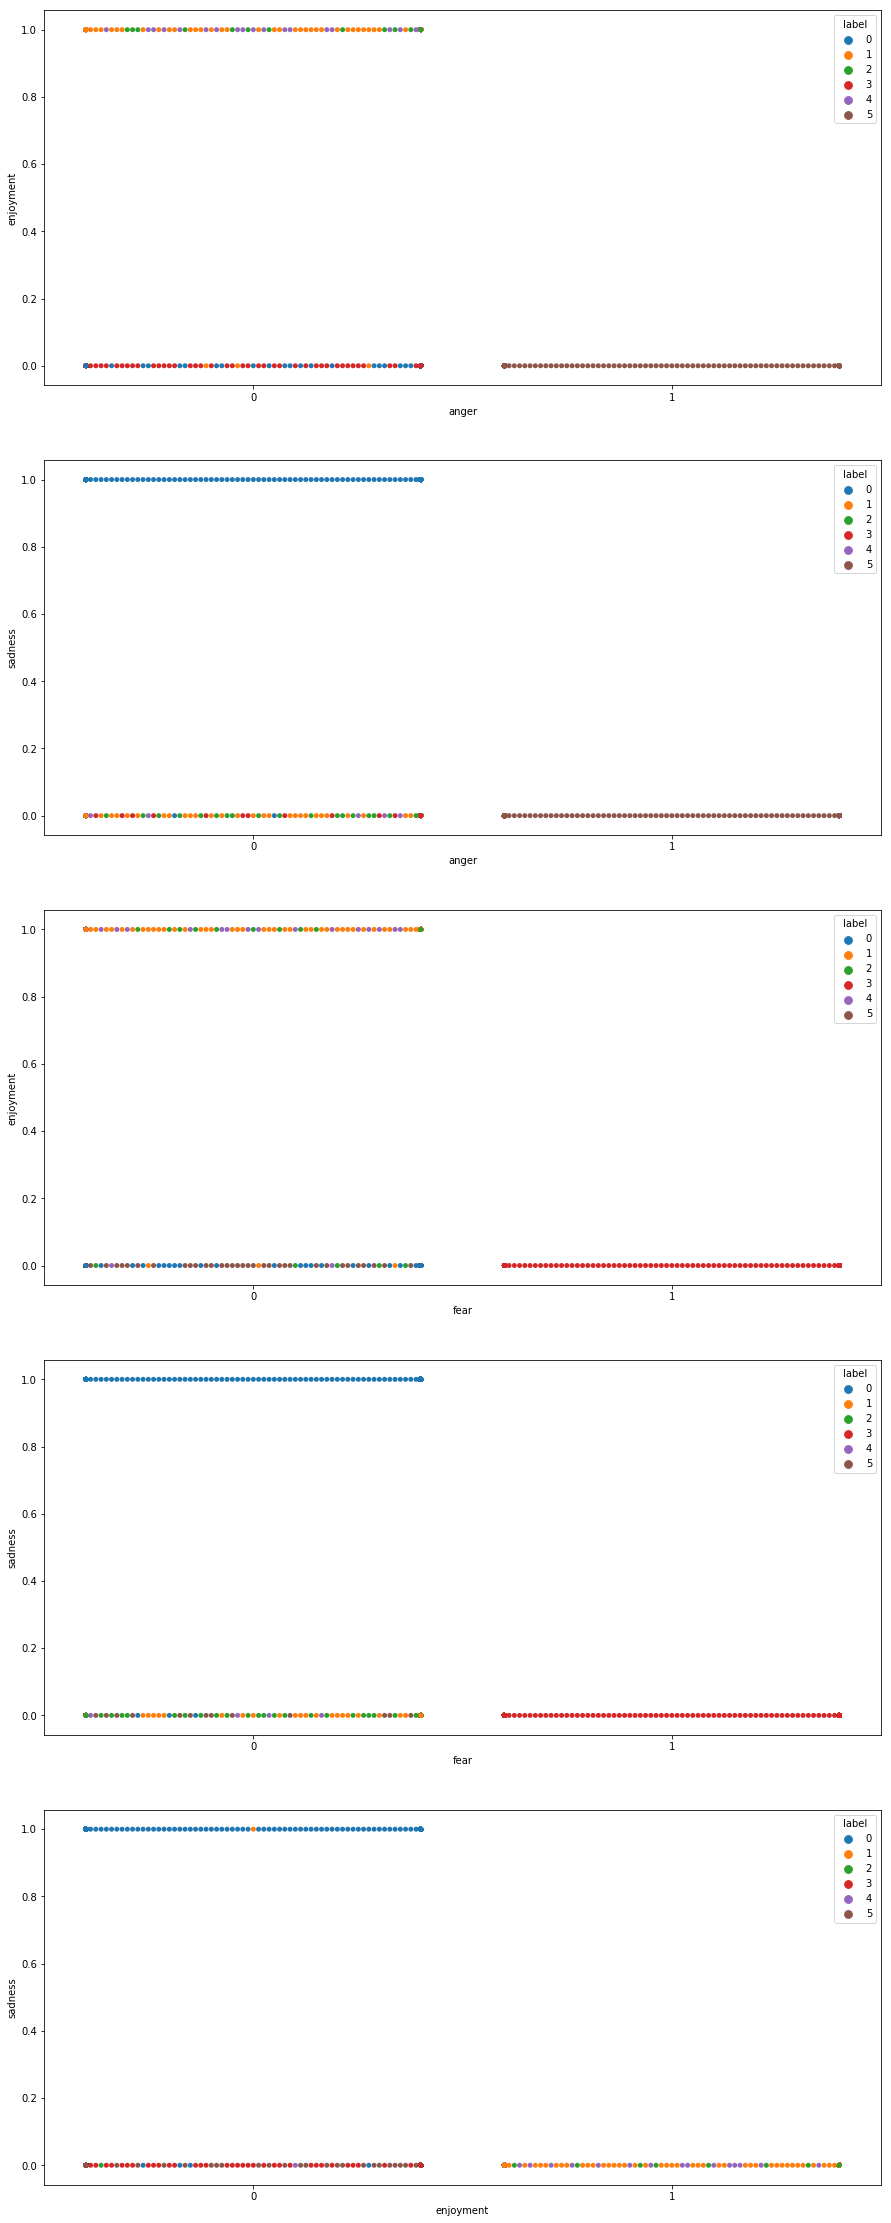

In [38]:
fig, ax = plt.subplots(5, 1, figsize=(15, 40))

emotions1 = ['anger', 'fear', 'enjoyment']
emotions2 = ['enjoyment', 'sadness']
num = 0

for e1 in emotions1:
    for e2 in emotions2:
        if e1 == e2:
            continue
        else:
            sns.swarmplot(x=e1, y=e2, hue='label', data=subset, ax=ax[num]);
            num += 1

# for i in range(6):
#     sns.swarmplot(x='intensity', y='bodySensationIntensity', data=test_subset[predictions == i], ax=ax[i]);

### Radar Charts

In [29]:
# col_list must begin with 'label' category to define clusters
scaler_radar = StandardScaler()
def prep_for_radar(df, col_list):
    df = df[col_list]
    clusters = df.iloc[:, 0].values
    df.drop(['label'], axis=1, inplace=True)
    scaler.fit(df)
    X = scaler.transform(df)
    return df, X, clusters

In [30]:
cols = ['label', 'anger', 'enjoyment', 'sadness', 'fear', 'intensity']
cols2 = ['label', 'intensity', 'emotionDuration', 'sadness', 'fear', 'enjoyment', 'anger']
cols3 = ['label', 'intensity', 'emotionDuration', 'bodySensationIntensity', 'sadness', 'fear', 'enjoyment', 'anger']
cols4 = ['label', 'tiredness', 'intensity', 'emotionDuration', 'bodySensationIntensity', 'workPilingUp']

In [31]:
df1, X1, clusters1 = prep_for_radar(subset, cols)
df2, X2, clusters2 = prep_for_radar(subset, cols2)
df3, X3, clusters3 = prep_for_radar(subset, cols3)
df4, X4, clusters4 = prep_for_radar(subset, cols4)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
np.unique(X3, return_counts=True)

(array([0.        , 0.04494382, 0.15730337, 0.25      , 0.3258427 ,
        0.5       , 0.66292135, 0.75      , 1.        ]),
 array([25761,  1359,  1468,  2708,  1384,  5561,   991,  3338,  9412]))

In [33]:
clusters1

array([4, 3, 0, ..., 5, 2, 5], dtype=int32)

In [60]:
# function to plot radar graph; modified slightly from Elliot's post (https://medium.com/@Saslow/high-dimensionality-visualization-in-python-65790a4b1719)

def plot_radar(df, X, clusters):
    # number of variable
    categories=list(df)
    N = len(categories)

    #Define the preset angles for your graph
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    #Get the mean values on all features from specific cluster
    values = X[clusters == 0].mean(axis = 0)

    #add value to the end so that the fill will work correctly
    values = np.append(values, values[:1])

    #create axis
    ax = plt.subplot(111, polar=True)

    # change the xticks and y ticks
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    plt.yticks([2,4,6], ["2","4","6"], color="grey", size=7)
    ax.set_rlabel_position(0)

    #Plot the values
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, alpha=0.2, label = 'Cluster 1')

    # Do it again for other clusters
    values = X[clusters == 1].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2, label = 'Cluster 2')

    # Do it again for other clusters
    values = X[clusters == 2].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2, label = 'Cluster 3')

    # Do it again for other clusters
    values = X[clusters == 3].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2, label = 'Cluster 4')

    # Do it again for other clusters
    values = X[clusters == 4].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2, label = 'Cluster 5')

    # And for the last cluster
    values = X[clusters == 5].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2, label = 'Cluster 6')

    plt.legend(bbox_to_anchor=(1, 1),
               bbox_transform=plt.gcf().transFigure)
    plt.title('Emotion Clusters on Radar Graph');
    plt.subplots_adjust(hspace=.8)

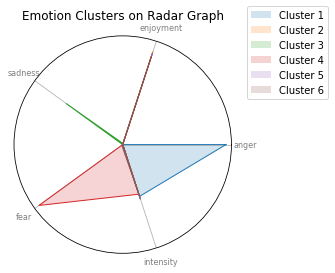

In [61]:
plot_radar(df1, X1, clusters1)

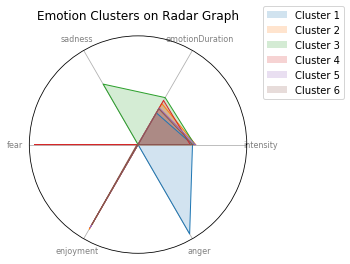

In [36]:
plot_radar(df2, X2, clusters2)

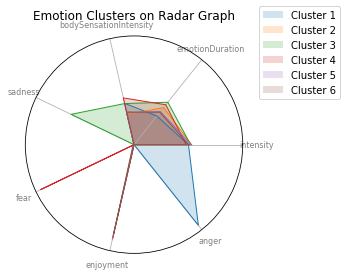

In [37]:
plot_radar(df3, X3, clusters3)

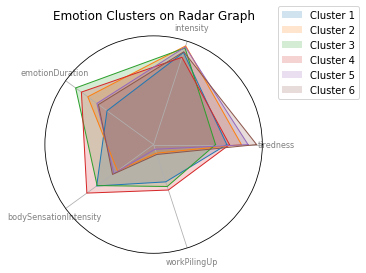

In [38]:
plot_radar(df4, X4, clusters4)

In [94]:
# function to plot radar graph; modified slightly from Elliot's post (https://medium.com/@Saslow/high-dimensionality-visualization-in-python-65790a4b1719)

def plot_radars(df, X, clusters):
    # number of variable
    categories=list(df)
    N = len(categories)

    #Define the preset angles for your graph
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    plt.figure(figsize=(14,14))    

    for i in range(6):
        ax = plt.subplot(3,3,i+1, polar=True)
        values = X[clusters == i].mean(axis = 0)
        values = np.append(values,values[:1])
        plt.xticks(angles[:-1], categories, color='grey', size=10)
        plt.yticks([2,4,6], ["2","4","6"], color="grey", size=7)
        ax.plot(angles, values, linewidth=1, linestyle='solid')#, color=plt.viridis)
        ax.fill(angles, values, alpha=0.2)#, color_palette='viridis')
        plt.title('Cluster {}'.format(i+1));
    
    ax.set_rlabel_position(0)
    plt.subplots_adjust(hspace=.8)    

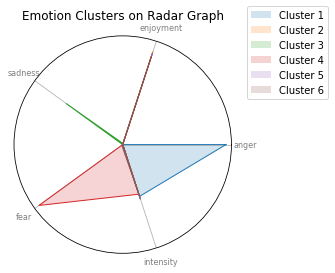

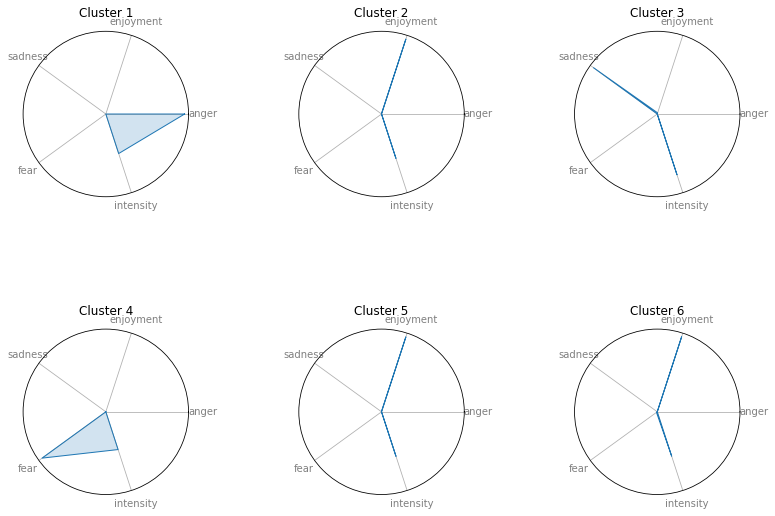

In [96]:
plot_radar(df1, X1, clusters1)
plot_radars(df1, X1, clusters1)

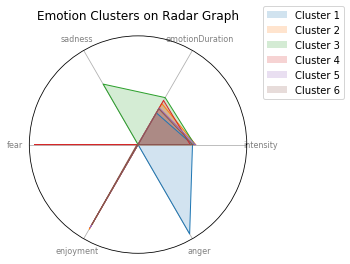

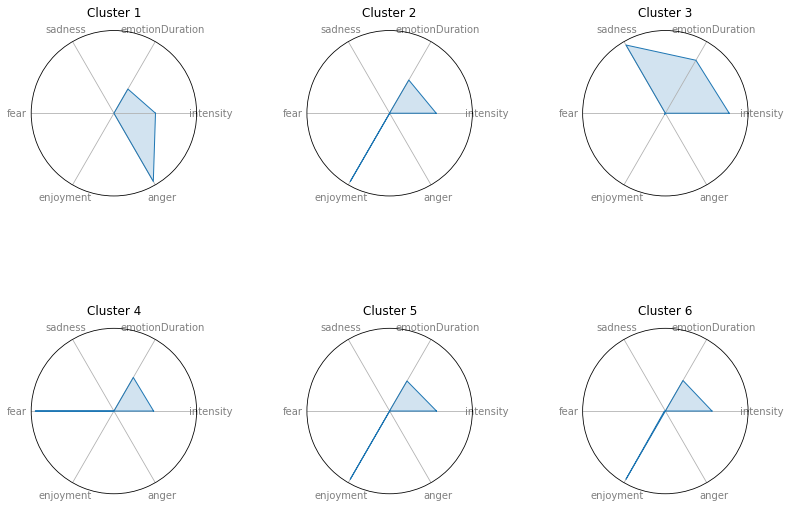

In [97]:
plot_radar(df2, X2, clusters2)
plot_radars(df2, X2, clusters2)

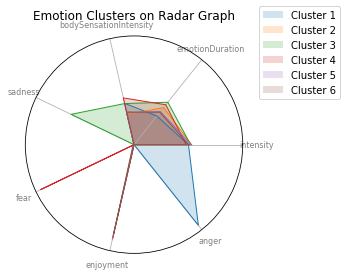

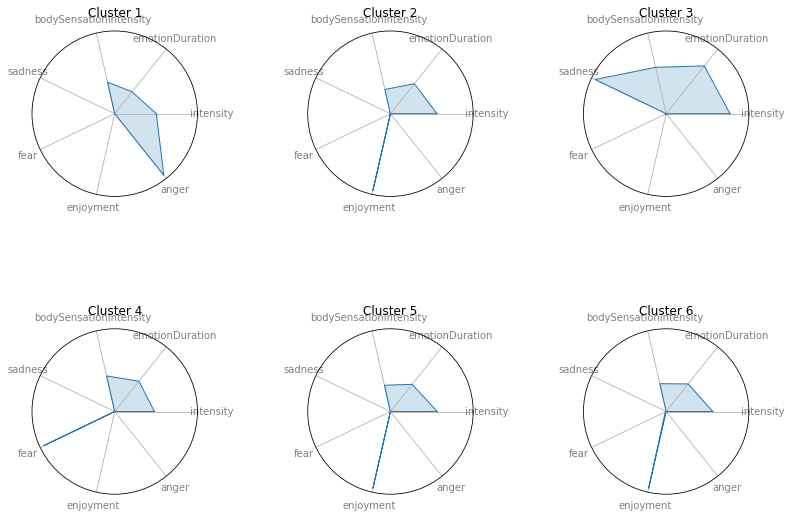

In [98]:
plot_radar(df3, X3, clusters3)
plot_radars(df3, X3, clusters3)

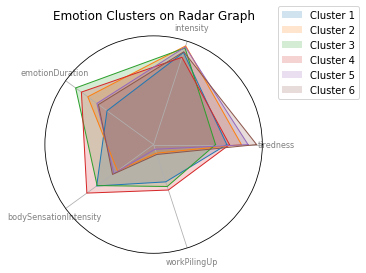

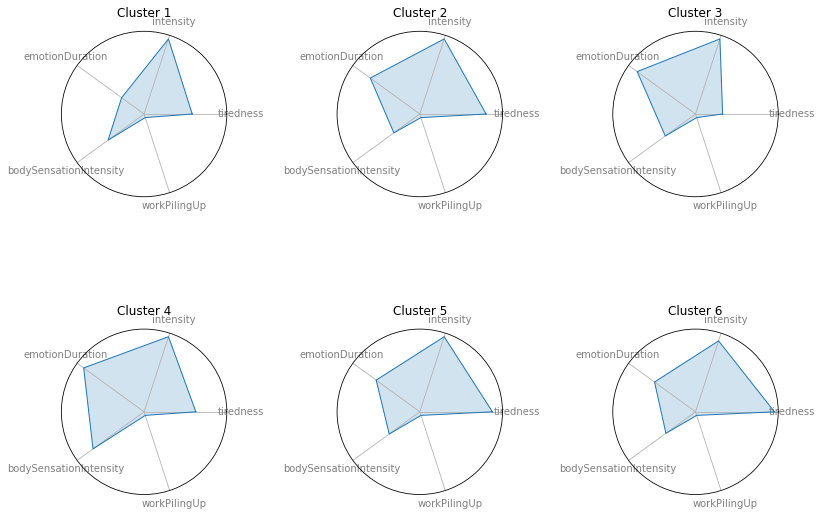

In [99]:
plot_radar(df4, X4, clusters4)
plot_radars(df4, X4, clusters4)